# IRASA

Notes:
- Is some kind of issue when using relatively short signals (below 10 seconds)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from neurodsp.sim import *
from neurodsp.spectral import compute_spectrum

from fooof.plts import plot_spectrum, plot_spectra

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.run import run_sims
from apm.plts.settings import AP_COL, COMB_COL

In [4]:
# Import IRASA
from code.irasa import irasa

## Settings

In [5]:
# Set whether to save out figures
SAVE_FIG = True

In [6]:
# General simulation settings
n_seconds = 10
fs = 1000

# Specific settings
default_exp = -1.5
default_freq = 10

# Collect together simulation parameters
sim_params_pow = {'n_seconds' : n_seconds, 'fs' : fs}

sim_params_comb = {'n_seconds' : n_seconds, 'fs' : fs, 
                   'components' : {'sim_powerlaw' : {'exponent' : default_exp},
                                   'sim_oscillation' : {'freq' : default_freq}}}

# Set the exponent range to simulate across
exps = np.arange(-3, 0.25, 0.25)
freqs = np.arange(1, 50, 1)
pows = np.arange(0, 3, 0.25)

# Set the number of instances to run
n_instances = 50

# IRASA settings
irasa_params = {'fs' : fs, 'band' : (1, 100)}

### Example: Powerlaw Signal

In [7]:
# Simulate a powerlaw signal
sig = sim_powerlaw(n_seconds, fs, default_exp)

In [8]:
# Calculate IRASA measure of exponent
psd_freqs, psd_ap, psd_osc, fit_params = irasa(sig, **irasa_params)

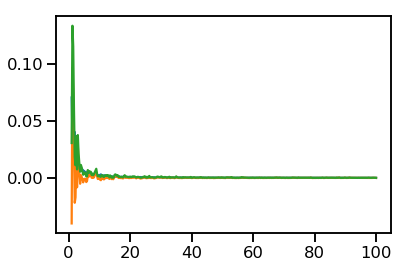

In [9]:
# Plot the different components of the power spectrum
plt.plot(psd_freqs, psd_ap[0, :])
plt.plot(psd_freqs, psd_osc[0, :])
plt.plot(psd_freqs, np.squeeze(psd_ap+psd_osc))

In [10]:
# Grab the calculate exponent value
fit_exp = fit_params['Slope'].values[0]

In [11]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(default_exp))

Measured Exponent:	 -1.4787
Expected Exponent:	 -1.5000


### Example: Knee Signal

In [12]:
# Expected exp for a synpatic activity signal, with a knee
exp_kn = -2

In [13]:
# Simulate a signal with a knee
sig_kn = sim_synaptic_current(n_seconds, fs)

In [14]:
# Calculate IRASA measure of exponent
psd_freqs, psd_ap, psd_osc, fit_params = irasa(sig_kn, **irasa_params)

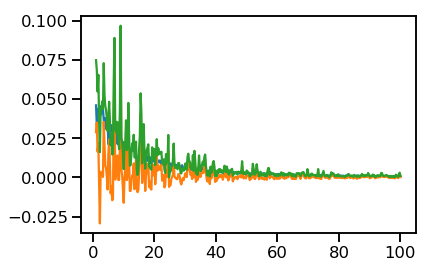

In [15]:
# Plot the different components of the power spectrum
plt.plot(psd_freqs, psd_ap[0, :])
plt.plot(psd_freqs, psd_osc[0, :])
plt.plot(psd_freqs, np.squeeze(psd_ap+psd_osc))

In [16]:
# Grab the calculate exponent value
fit_exp = fit_params['Slope'].values[0]

In [17]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(exp_kn))

Measured Exponent:	 -1.2338
Expected Exponent:	 -2.0000


### Helper Functions

In [18]:
def irasa_wrapper(sig, **kwargs):
    return irasa(sig, **kwargs)[3]['Slope'][0]

## IRASA Simulation Tests

### Powerlaw Signals - Across Exponents

In [19]:
# Run a set of simulations, calculating IRASA estimation across exponents
irasa_sims_exp = run_sims(sim_powerlaw, sim_params_pow, irasa_wrapper, irasa_params,
                          update='update_exp', values=exps, n_instances=n_instances)

Text(0, 0.5, 'Measured Exponent')

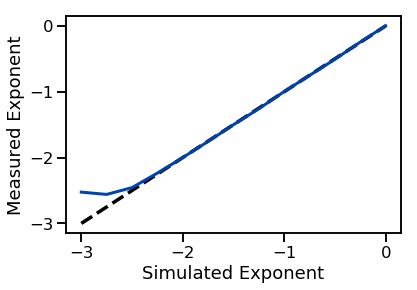

In [20]:
# Plot IRASA estimation across exponents
plt.plot(exps, exps, 'k--', lw=3.5)
plt.plot(exps, irasa_sims_exp, lw=3, color=AP_COL)

plt.xlabel('Simulated Exponent')
plt.ylabel('Measured Exponent')

### Powerlaw Signals with Oscillations - Across Exponents

In [21]:
# Run a set of simulations, calculating IRASA estimation across exponents
irasa_sims_comb_exp = run_sims(sim_combined, sim_params_comb, irasa_wrapper, irasa_params,
                          update='update_comb_exp', values=exps, n_instances=n_instances)

Text(0, 0.5, 'Measured Exponent')

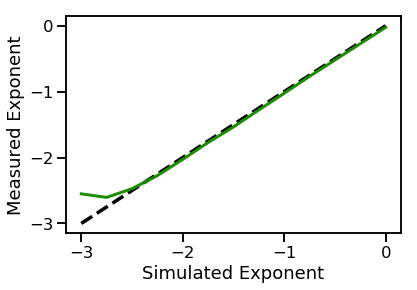

In [22]:
# Plot IRASA estimation across exponents, with oscillation
plt.plot(exps, exps, 'k--', lw=3.5)
plt.plot(exps, irasa_sims_comb_exp, lw=3, color=COMB_COL)

plt.xlabel('Simulated Exponent')
plt.ylabel('Measured Exponent')

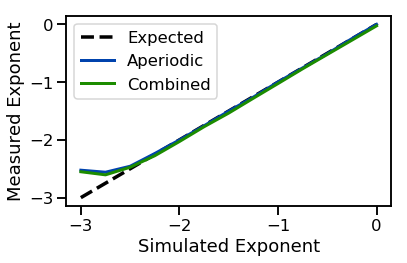

In [23]:
# Plot IRASA estimation across exponents, both with and without oscillation
plt.plot(exps, exps, 'k--', label='Expected', lw=3.5)
plt.plot(exps, irasa_sims_exp, label='Aperiodic', lw=3, color=AP_COL)
plt.plot(exps, irasa_sims_comb_exp, label='Combined', lw=3, color=COMB_COL)

plt.xlabel('Simulated Exponent')
plt.ylabel('Measured Exponent')

plt.legend()

plt.tight_layout()

if SAVE_FIG: plt.savefig('plts/irasa-both.pdf')

### Powerlaw Signals with Oscillations - Across Oscillation Frequency

In [24]:
# Run a set of simulations, calculating IRASA across oscillation frequencies
irasa_sims_freq = run_sims(sim_combined, sim_params_comb, irasa_wrapper, irasa_params,
                           update='update_freq', values=freqs, n_instances=n_instances)

Text(0, 0.5, 'Measured Exponent')

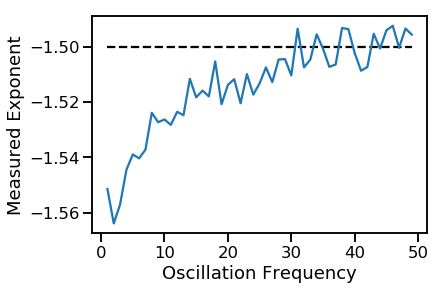

In [25]:
# Plot IRASA estimation across oscillation frequency values
plt.plot(freqs, [default_exp]*len(freqs), 'k--')
plt.plot(freqs, irasa_sims_freq)

plt.xlabel('Oscillation Frequency')
plt.ylabel('Measured Exponent')

### Powerlaw Signals with Oscillations - Across Oscillation Power

In [26]:
# Run a set of simulations, calculating IRASA across oscillation power
irasa_sims_pow = run_sims(sim_combined, sim_params_comb, irasa_wrapper, irasa_params,
                          update='update_pow', values=pows, n_instances=n_instances)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Measured Exponent')

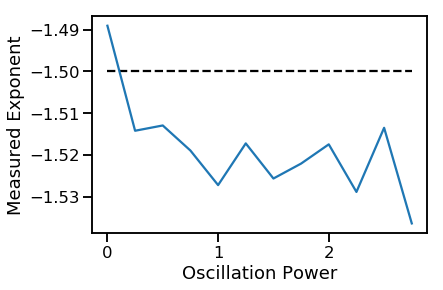

In [27]:
# Plot IRASA estimation across oscillation frequency values
plt.plot(pows, [default_exp]*len(pows), 'k--')
plt.plot(pows, irasa_sims_pow)

plt.xlabel('Oscillation Power')
plt.ylabel('Measured Exponent')